## Transfer-Learning

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

--2021-04-20 21:06:22--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  71.1MB/s    in 1.2s    

2021-04-20 21:06:23 (71.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



`InceptionV3()`


In [2]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150,150,3), weights = None, include_top = False) 
# the InceptionV3 has a fully connected layer to the top,
# by setting False you ignore them and go straight to the convolutions

pre_trained_model.load_weights(local_weights_file) # Load the downloaded weights

In [3]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
last_layer.output_shape
last_output = last_layer.output

## Last layers

In [5]:
from tensorflow.keras.optimizers import RMSprop
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Load data and preprocess pipeline

In [6]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-04-20 21:06:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  82.5MB/s    in 0.8s    

2021-04-20 21:06:30 (82.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [7]:
train = '/tmp/cats_and_dogs_filtered/train'
val = '/tmp/cats_and_dogs_filtered/validation'

train_cats_dir = os.path.join(train, 'cats')
train_dogs_dir = os.path.join(train, 'dogs')
val_cats_dir = os.path.join(val, 'cats')
val_dogs_dir = os.path.join(val, 'dogs')
train_cats_names = os.listdir(train_cats_dir)
train_dogs_names = os.listdir(train_dogs_dir)
val_cats_names = os.listdir(val_cats_dir)
val_dogs_names = os.listdir(val_dogs_dir)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
  height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train, batch_size=20,
                                                    class_mode='binary', target_size=(150,150))
validation_generator =  test_datagen.flow_from_directory( val, batch_size  = 20,
                                                          class_mode  = 'binary', target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
history = model.fit(train_generator, validation_data=validation_generator, 
                    steps_per_epoch=100, epochs=20, validation_steps=50, verbose=2)

Epoch 1/20
100/100 - 40s - loss: 0.3595 - accuracy: 0.8645 - val_loss: 0.1141 - val_accuracy: 0.9570
Epoch 2/20
100/100 - 19s - loss: 0.2171 - accuracy: 0.9145 - val_loss: 0.2410 - val_accuracy: 0.9200
Epoch 3/20
100/100 - 19s - loss: 0.2162 - accuracy: 0.9230 - val_loss: 0.1639 - val_accuracy: 0.9390
Epoch 4/20
100/100 - 19s - loss: 0.1817 - accuracy: 0.9350 - val_loss: 0.1008 - val_accuracy: 0.9670
Epoch 5/20
100/100 - 19s - loss: 0.1872 - accuracy: 0.9345 - val_loss: 0.1210 - val_accuracy: 0.9640
Epoch 6/20
100/100 - 19s - loss: 0.1591 - accuracy: 0.9405 - val_loss: 0.1071 - val_accuracy: 0.9650
Epoch 7/20
100/100 - 19s - loss: 0.1667 - accuracy: 0.9420 - val_loss: 0.0990 - val_accuracy: 0.9700
Epoch 8/20
100/100 - 19s - loss: 0.1711 - accuracy: 0.9420 - val_loss: 0.1162 - val_accuracy: 0.9650
Epoch 9/20
100/100 - 19s - loss: 0.1598 - accuracy: 0.9455 - val_loss: 0.1087 - val_accuracy: 0.9710
Epoch 10/20
100/100 - 19s - loss: 0.1569 - accuracy: 0.9455 - val_loss: 0.1182 - val_accura

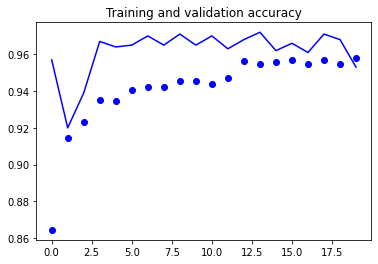

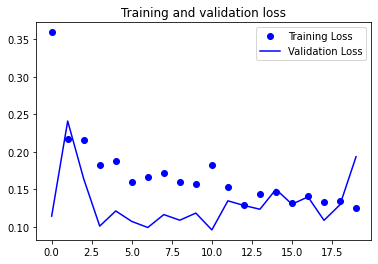

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()